# core

> Utils function to monitor the gradients of different loss term
>
> Suppose we optimize for the loss
> $$\mathcal{L} = \mathcal{L}_{rec} + \mathcal{L}_{reg}$$
> 
> If we train with the standard method `loss.backward()`, it is not possible to recover $\nabla \mathcal{L}_{rec}$ and $\nabla \mathcal{L}_{reg}$ independently.
>
> I propose functions to monitor the loss and gradients as Python decorators.
>
> Related StackO topics:
>   - https://stackoverflow.com/questions/69448198/get-grads-of-parameters-w-r-t-a-loss-term-in-pytorch

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
# | export
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from catalyst import utils as ctutils
import seaborn as sns
from mlp_monitor.utils import lookahead
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#| hide
sns.set(style="darkgrid", font_scale=1.4)
%config InlineBackend.figure_format = 'retina'

## Loss functions

### Monitor the losses

In [ ]:
# | export
import pandas as pd
from functools import wraps


class LossMonitor:
    """Parametrized decorator, name with be used to store loss function."""

    def __init__(self, name):
        self.name = name
        self._losses = []

    @property
    def losses(self):
        return pd.DataFrame.from_dict(self._losses)

    def __call__(self, method):
        """Decorator to log loss functions"""

        @wraps(method)
        def _loss(*method_args, batch=None, epoch=None, **method_kwargs):
            l = method(*method_args, **method_kwargs)
            self._losses.append(
                {self.name: l.detach().cpu().numpy()} | {"Epoch": epoch, "Batch": batch}
            )
            return l

        _loss.__name__ = self.name
        return _loss

    def plot(self, ax=None):
        if ax is None:
            ax = plt.gca()
        return ax.plot(range(len(self.losses)), self.losses, label=self.name)

    def reset(self):
        self._losses = []

In [ ]:
{"a": 1}.pop("a")

1

In [ ]:
# import functools

# def wraps_partial(wrapper, *args, **kwargs):
#     """ Creates a callable object whose attributes will be set from the partials nested func attribute ..."""
#     wrapper = wrapper.func
#     while isinstance(wrapper, functools.partial):
#         wrapper = wrapper.func
#     return functools.wraps(wrapper, *args, **kwargs)

# def mydec(fun):
#     @wraps(fun)
#     def inner(*args, **kw):
#         return fun(*args, **kw)
#     return inner

# @mydec
# def myfun(): print("coucou")

# myfun.__name__

In [ ]:
# | export
reg_monitor = LossMonitor("Reg")
@reg_monitor
def loss_l1(model, factor=0.0005):
    l1_crit = nn.L1Loss(reduction="mean")
    reg_loss = 0
    for param in model.parameters():
        reg_loss += l1_crit(param, torch.zeros(param.size()))

    return factor * reg_loss


rec_monitor = LossMonitor("Rec")
# @rec_monitor
# def loss_rec(x_pred, x_true):
#     return nn.functional.cross_entropy(x_pred, x_true)

loss_rec = rec_monitor(nn.BCEWithLogitsLoss())
loss_rec.__name__

'Rec'

## Model

In [ ]:
#| export
class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim = 30) -> None:
        super().__init__()
        self.input_dim = input_dim
        seq = [
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        ]
        self.seq = nn.Sequential(*seq)

    def forward(self, x):
        return self.seq(x)


## Dataset

In [ ]:
from sklearn.datasets import make_moons, make_circles, make_blobs

def to_torch(x, fmt=torch.float32):
    return torch.from_numpy(x).to(fmt)

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.07)
dataset = TensorDataset(to_torch(X), to_torch(y))
dataloader = DataLoader(dataset, batch_size=128,  shuffle=False)

### Plotting

In [ ]:
#| export
from matplotlib import pyplot as plt

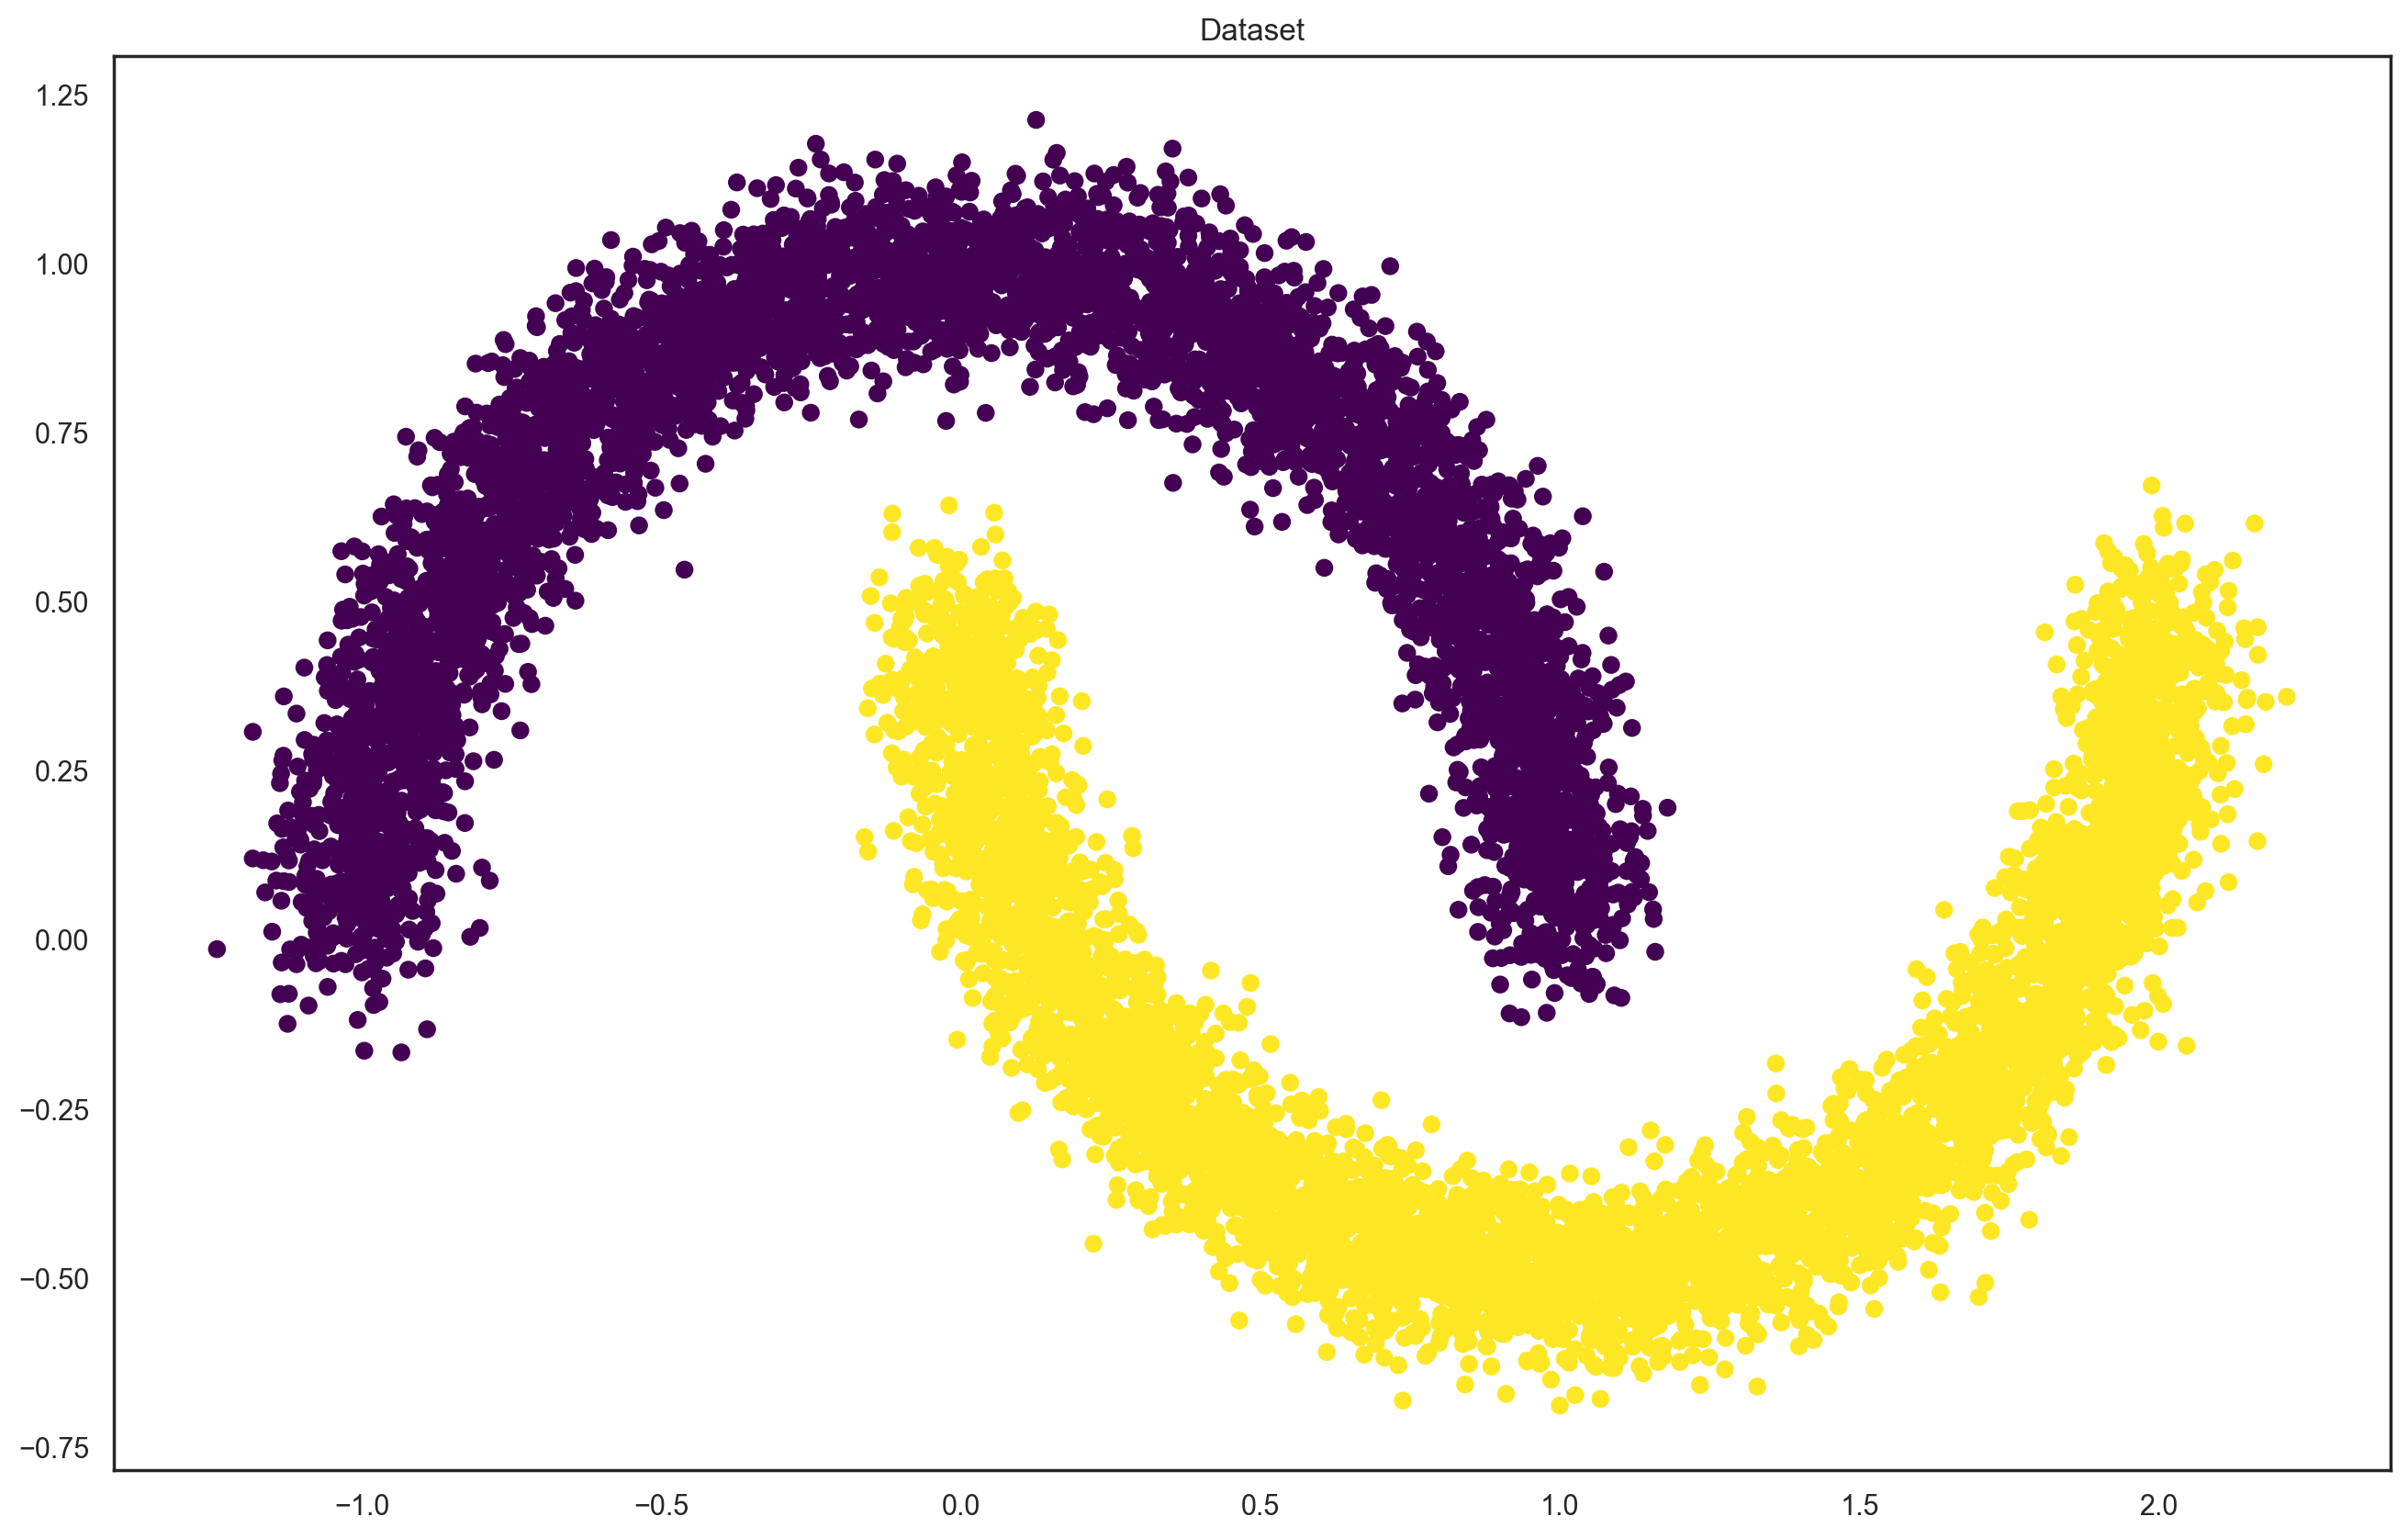

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

## Training

### Gradient utils

In [ ]:
def get_grad(model):
    return [param.grad.clone() for param in model.parameters()]


def reset_grad(model):
    for param in model.parameters():
        param.grad = None


def assign_grad(model, grad):
    for param, g in zip(model.parameters(), grad):
        param.grad = g


def norm_grad(grad):
    return torch.linalg.norm(
        torch.concat([g.flatten() for g in grad])
    )


In [ ]:
class AdditiveLoss:
    def __init__(self, loss_fcts, model):
        self.loss_fcts = loss_fcts
        self.model = model
        self.grads = []

    def __call__(self, loss_args, batch, epoch):
        grads = {}
        losses = []
        for (loss, args),  has_more in lookahead(zip(self.loss_fcts, loss_args)):
            _loss = loss(*args)
            _loss.backward(retain_graph=has_more)
            losses.append(_loss)
            grads[loss.__name__] = get_grad(self.model)
            reset_grad(self.model)
        assign_grad(self.model, [sum(g) for g in zip(*grads.values())])
        self.grads.append({k:norm_grad(g) for k, g in grads.items()} | {"Epoch": epoch, "Batch": batch})
        return sum(losses)

In [ ]:
model = MLP(X.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
full_loss = AdditiveLoss([loss_rec, loss_l1], model)
rec_monitor.reset()
reg_monitor.reset()

In [ ]:
epochs = 200
base_seed = 42
grads = {"rec": [], "reg": []}
for epoch in range(epochs):
    ctutils.set_global_seed(base_seed + epoch)
    for ibatch, (X_batch, y_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        outp = model(X_batch).reshape(-1)
        loss = full_loss(
            (
                (outp, y_batch),
                (model, .001)
            ),
            ibatch, epoch)
        # _lrec = loss_rec(outp, y_batch)
        # _lreg = loss_l1(model, factor=1e-3)

        # _lrec.backward(retain_graph=True)
        # _grec = get_grad(model)
        # reset_grad(model)
        # _lreg.backward()
        # _greg = get_grad(model)
        # assign_grad(model, [x + y for x, y in zip(_grec, _greg)])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        # grads["rec"].append(norm_grad(_grec))
        # grads["reg"].append(norm_grad(_greg))

In [ ]:
def show_loss(*monitors):
    plt.figure(figsize=(12, 8))
    for m in monitors:
        m.plot()
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both")
    plt.show()

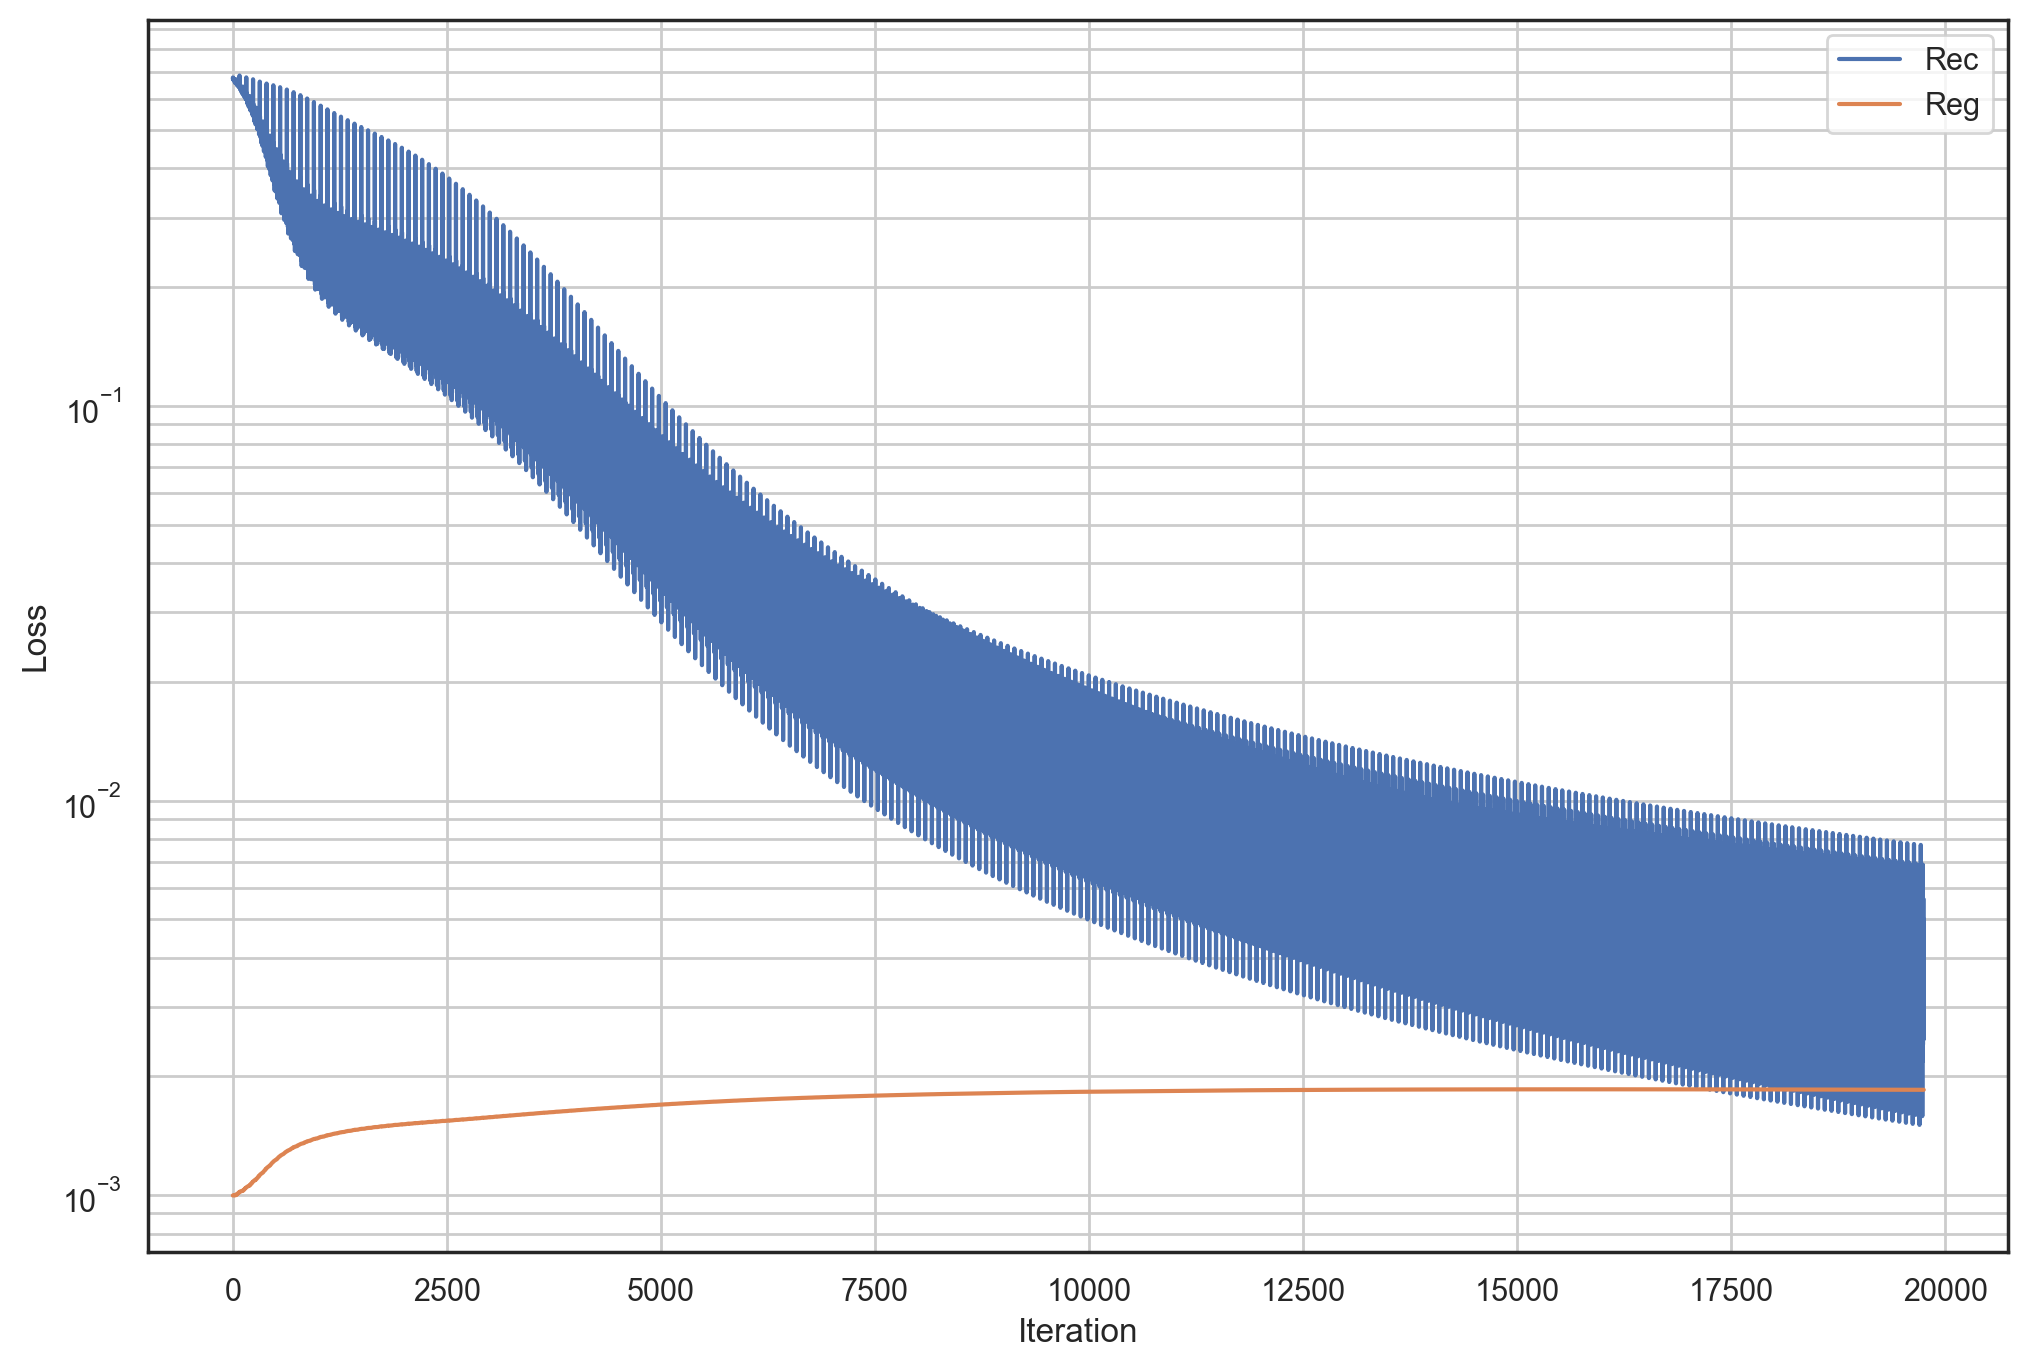

In [ ]:
show_loss(rec_monitor, reg_monitor)

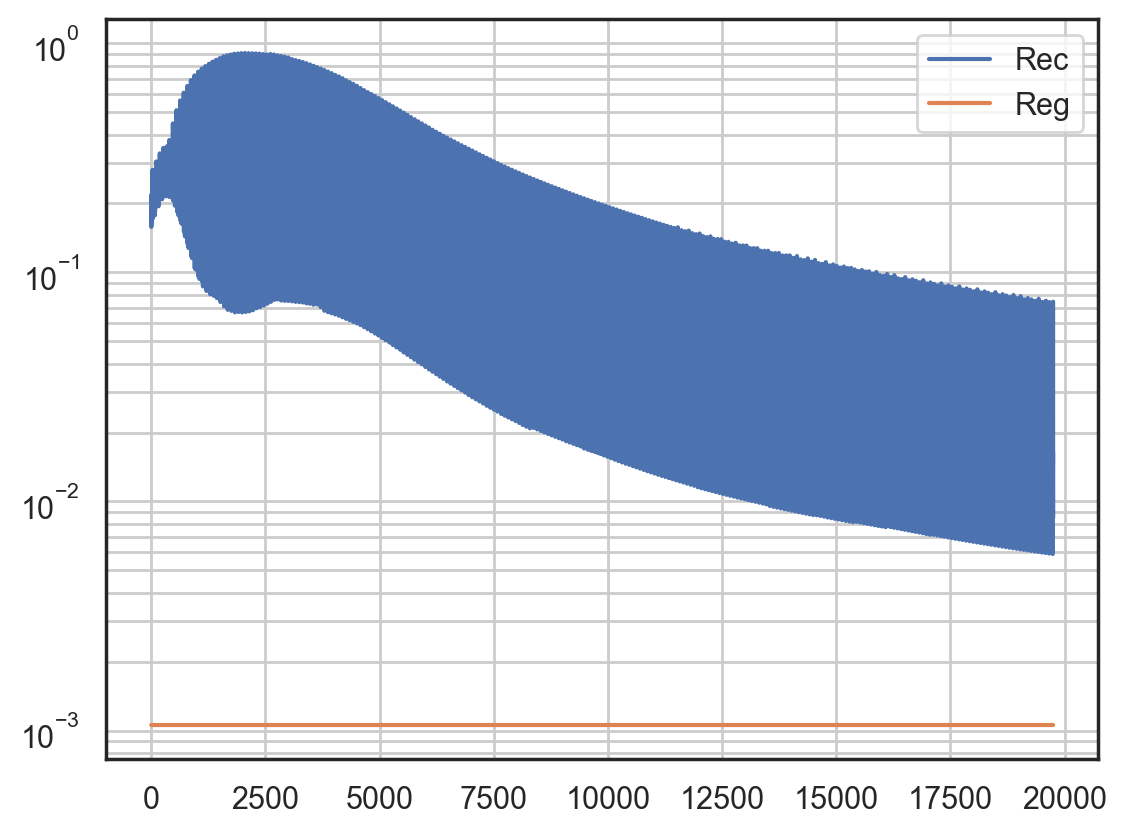

In [ ]:
def plot_grad(name, data):
    plt.plot(data[name], label=name)


_data = pd.DataFrame.from_dict(full_loss.grads)
plot_grad("Rec", _data)
plot_grad("Reg", _data)
plt.yscale("log")
plt.legend()
plt.grid(True, which="both")

In [ ]:
def show_separation(model, save=False, name_to_save="", n_scatter=1000, check=False):
    sns.set(style="white")

    xx, yy = np.mgrid[-1.5:2.5:0.01, -1.0:1.5:0.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    batch = torch.from_numpy(grid).type(torch.float32)
    with torch.no_grad():
        probs = torch.sigmoid(model(batch).reshape(xx.shape))
        probs = probs.numpy().reshape(xx.shape)

        if check: # simple check
            assert probs.max() > .9
            assert probs.min() < .1
    f, ax = plt.subplots(figsize=(16, 10))
    ax.set_title("Decision boundary", fontsize=14)
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])

    ax.scatter(
        X[:n_scatter, 0],
        X[:n_scatter, 1],
        c=y[:n_scatter],
        s=50,
        cmap="RdBu",
        vmin=-0.2,
        vmax=1.2,
        edgecolor="white",
        linewidth=1,
    )

    ax.set(xlabel="$X_1$", ylabel="$X_2$")
    if save:
        plt.savefig(name_to_save)
    else:
        plt.show()

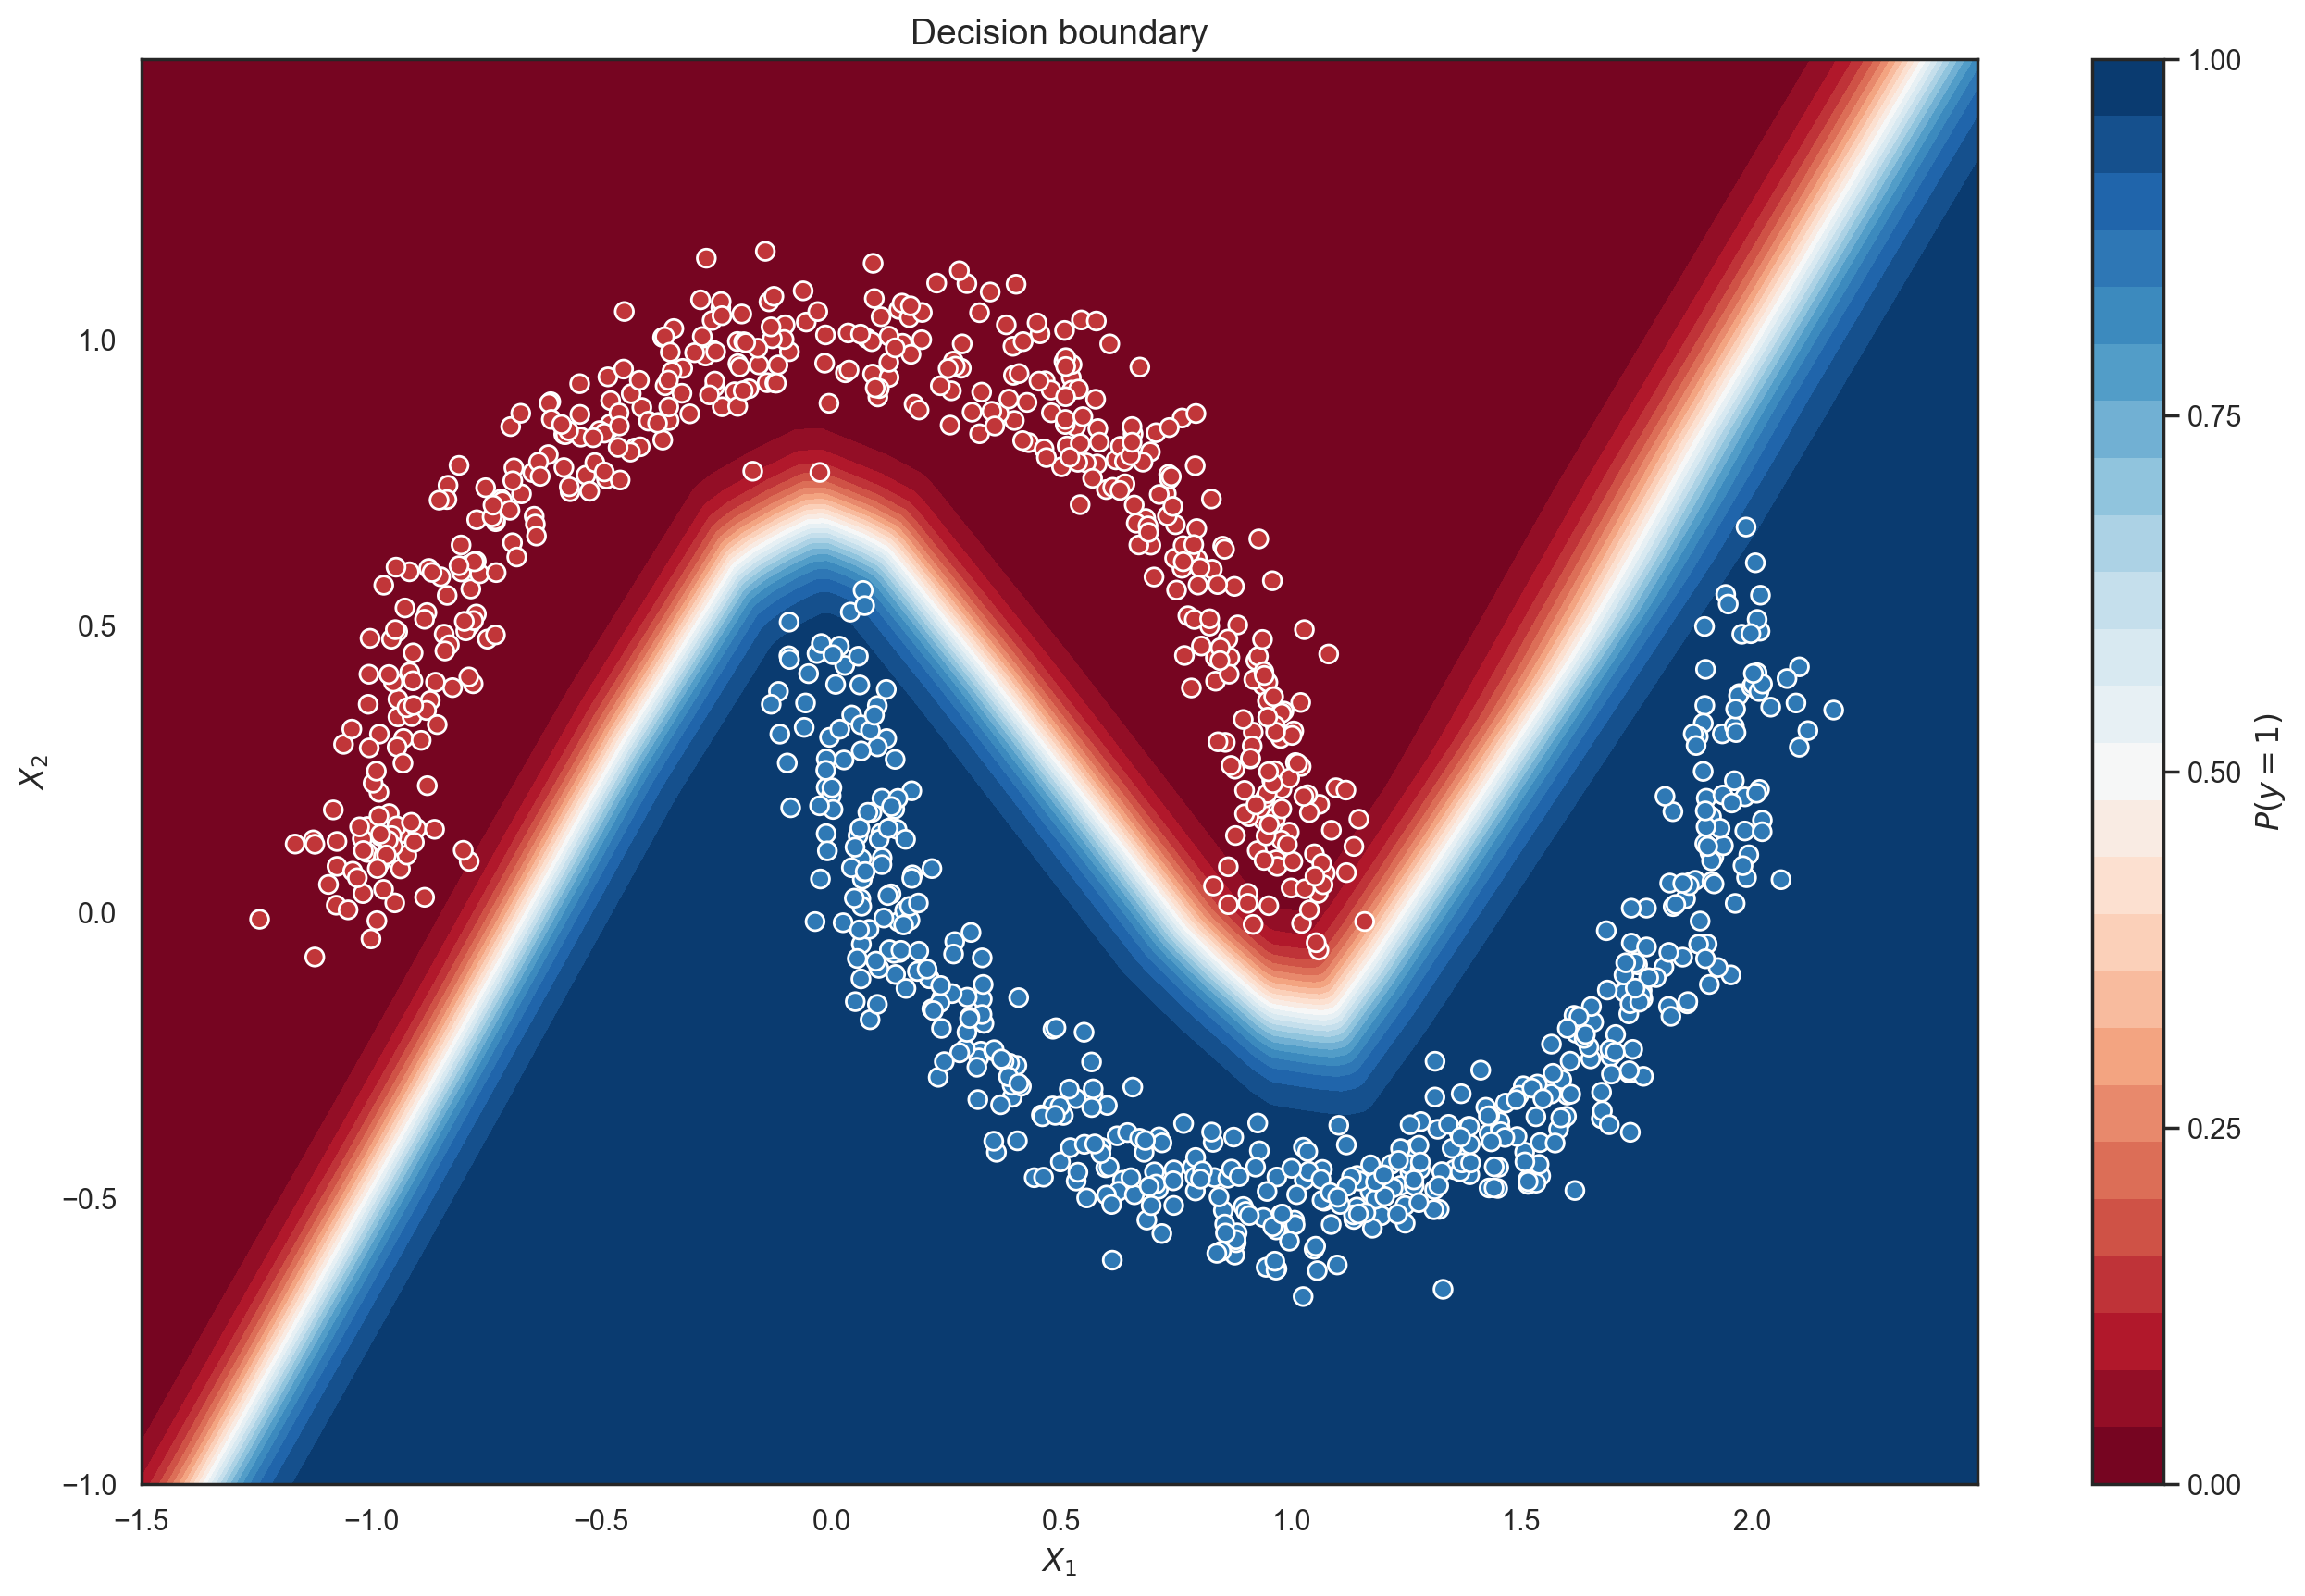

In [ ]:
show_separation(model)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()